In [ ]:
!pip install wandb

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
import wandb
from wandb.keras import WandbCallback
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
wandb.init(project="17_Flowers")

In [ ]:
width = height = 299
batch_size = 32
train_dataset_path = "/content/drive/MyDrive/Flowers/Train"

idg = ImageDataGenerator(
    rescale = 1./255,

    #Augmentation
    horizontal_flip = True,
    rotation_range = 10,
    brightness_range = (0.8, 1.2),
    shear_range = 0.1,
    zoom_range = 0.2,
    validation_split = 0.2
)

train_data = idg.flow_from_directory(
    train_dataset_path,
    target_size = (width, height),
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "training"
)

val_data = idg.flow_from_directory(
    train_dataset_path,
    target_size = (width, height),
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "validation"
)

Found 884 images belonging to 17 classes.
Found 204 images belonging to 17 classes.


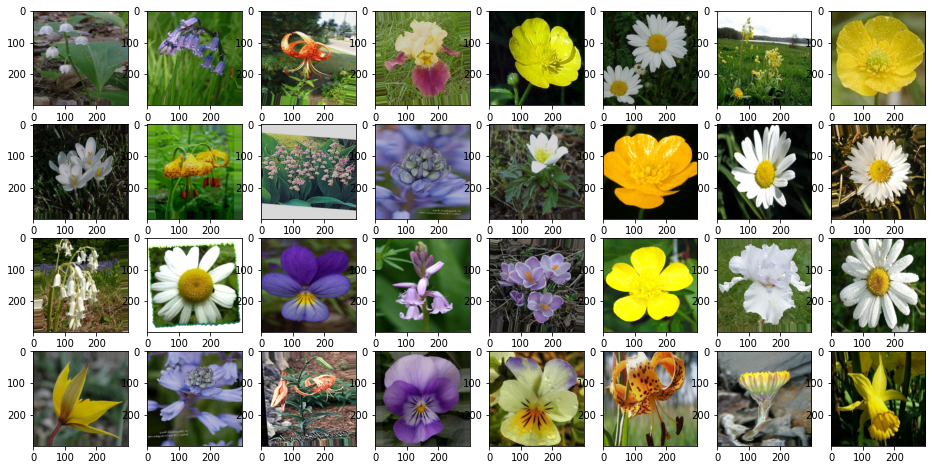

In [ ]:
X, Y = next(train_data)

plt.figure(figsize=(16, 8))
for i in range(32):
  plt.subplot(4, 8, i+1)
  plt.imshow(X[i])

### Model

In [ ]:
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(width, height, 3),
    pooling="avg"
)

In [ ]:
for layer in base_model.layers[:-4]:
  layer.trainable = False

In [ ]:
base_model.summary()

In [ ]:
model = tf.keras.models.Sequential([
    base_model,
    Dense(1024, activation="relu"),
    Dropout(0.2),
    Dense(17, activation="softmax")
])

In [ ]:
config = wandb.config
config.learning_rate = 0.001

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=["accuracy"])

In [ ]:
model.fit(train_data, validation_data=val_data, epochs=10, callbacks=[WandbCallback()])

Epoch 1/10
28/28 [==============================] - 46s 1s/step - loss: 1.8990 - accuracy: 0.4695 - val_loss: 0.7944 - val_accuracy: 0.7598 - _timestamp: 1647625546.0000 - _runtime: 79.0000
Epoch 2/10
28/28 [==============================] - 38s 1s/step - loss: 0.5511 - accuracy: 0.8360 - val_loss: 0.3819 - val_accuracy: 0.8775 - _timestamp: 1647625584.0000 - _runtime: 117.0000
Epoch 3/10
28/28 [==============================] - 39s 1s/step - loss: 0.3219 - accuracy: 0.9152 - val_loss: 0.3680 - val_accuracy: 0.8725 - _timestamp: 1647625623.0000 - _runtime: 156.0000
Epoch 4/10
28/28 [==============================] - 38s 1s/step - loss: 0.2678 - accuracy: 0.9197 - val_loss: 0.3388 - val_accuracy: 0.8873 - _timestamp: 1647625661.0000 - _runtime: 194.0000
Epoch 5/10
28/28 [==============================] - 38s 1s/step - loss: 0.2185 - accuracy: 0.9321 - val_loss: 0.3274 - val_accuracy: 0.9020 - _timestamp: 1647625699.0000 - _runtime: 232.0000
Epoch 6/10
28/28 [============================

### Test

In [ ]:
test_dataset_path = "/content/drive/MyDrive/Flowers/Test"

idg = ImageDataGenerator(
    rescale = 1./255,
)

test_data = idg.flow_from_directory(
    train_dataset_path,
    target_size = (width, height),
    batch_size = batch_size,
    class_mode = "categorical"
)

Found 1088 images belonging to 17 classes.


In [ ]:
model.evaluate(test_data)

34/34 [==============================] - 12s 350ms/step - loss: 0.1040 - accuracy: 0.9697


[0.10397583991289139, 0.9696691036224365]

In [ ]:
Y_pred = []
for img_path in test_data.filepaths:
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (width, height))
  img = img.reshape(1, width, height, 3) # 3d ---> 4d
  img = img / 255.0
  y_pred = np.argmax(model.predict(img))
  Y_pred.append(y_pred)

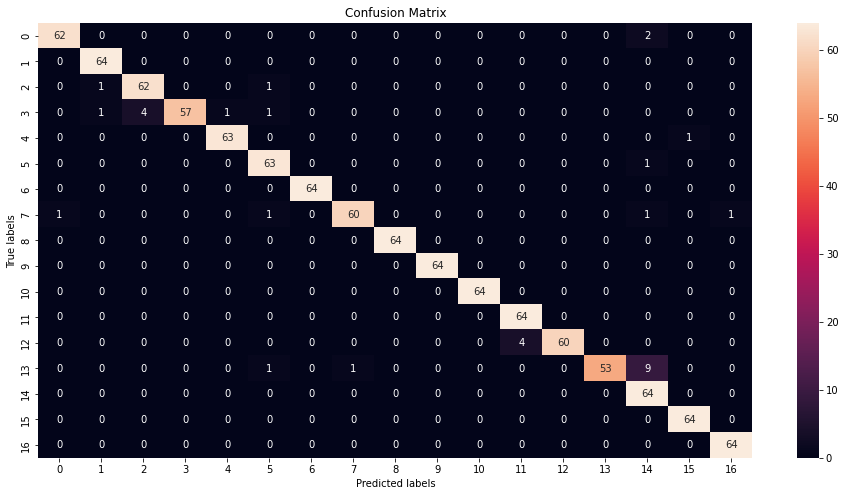

In [ ]:
Y_true = test_data.classes
conf_matrix = confusion_matrix(Y_true, Y_pred)

plt.figure(figsize=(16, 8))
ax = sns.heatmap(conf_matrix, annot=True)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

### Save Model

In [ ]:
model.save("drive/MyDrive/17-Flowers/flowersClassification.h5")